# The Daubechies D4 Wavelet Tranform

In [112]:
import numpy as np
import cv2
import IPython
from PIL import Image
import matplotlib.pyplot as plt


def split_matrix(mat): # divide the matrix into 4 quadrants
    h, w = mat.shape
    return mat[:h // 2, :w // 2], mat[:h // 2, w // 2:], mat[h // 2:, :w // 2], mat[h // 2:, w // 2:]

def concatenate_matrices(m1, m2, m3, m4):
    return np.concatenate((np.concatenate((m1, m2), axis=1),
                            np.concatenate((m3, m4), axis=1)), axis=0)

def imshow(image, width=None):
    _, ret = cv2.imencode('.jpg', image)
    i = IPython.display.Image(data=ret, width=width)
    IPython.display.display(i)

def jpg_to_pgm(jpg_path):
    image = Image.open(jpg_path)
    image_gray = image.convert('L')
    width = image_gray.size[0]
    if (width>512):
        image_gray = image_gray.resize((512, 512))
        pixels = list(image_gray.getdata())

    else: pixels = list(image_gray.getdata())

    return np.array(pixels).reshape((512, 512))

def new_p(matrix):
    max,min  = np.max(matrix), np.min(matrix)
    for i in range(len(matrix)):
        for j in range(len(matrix[i])):
            matrix[i][j] = ((matrix[i][j]-min)*255.0)/(max-min)
    return matrix


def function_daubechies_coeffs(image):
    rows, cols = image.shape
    matrix_coeffs = np.zeros((rows, cols))

    for i in range(rows // 2):
        if i < rows // 2 - 1: 
            matrix_coeffs[i, 2 * i:2 * i + 4] = h_coeffs
        else:
            matrix_coeffs[i, 2 * i:2 * i + 2] = h_coeffs[:2]
            matrix_coeffs[i, 0:2] = h_coeffs[2:]

    for i in range(rows // 2):
        if i < rows // 2 - 1:
            matrix_coeffs[i + rows // 2, 2 * i:2 * i + 4] = g_coeffs
        else:
            matrix_coeffs[i + rows // 2, 2 * i:2 * i + 2] = g_coeffs[:2]
            matrix_coeffs[i + rows // 2, 0:2] = g_coeffs[2:]

    return (np.round(matrix_coeffs, 4))


def daubechies4_wavelet_transform_2D(daubechies_coeffs,image,scale,width, details = None):
    result_H = []

    for row in image: #ESTA PARTE HACE LA HORIZONTAL
        result_H.append(np.dot(daubechies_coeffs,row))
    result_V = np.dot(daubechies_coeffs,result_H)

    if (scale == 1) :
        if details is not None:
            normalized = np.copy(result_V)
            for i in range(len(details)//3):
                result_V = concatenate_matrices(result_V,details[0+(i*3)],details[1+(i*3)],details[2+(i*3)])

                aP,cH,cV,cD = split_matrix(normalized)
                normalized = concatenate_matrices(new_p(aP),new_p(cH),new_p(cV),new_p(cD))
                normalized = concatenate_matrices(new_p(normalized),new_p(details[0+(i*3)]),new_p(details[1+(i*3)]),new_p(details[2+(i*3)])) ########
  
            return result_V, normalized
        else:
            normalized = np.copy(result_V)
            aP,cH,cV,cD = split_matrix(normalized)
            normalized = concatenate_matrices(new_p(aP),new_p(cH),new_p(cV),new_p(cD))

            return result_V, normalized
        
    elif (np.log2(width//4) >= scale > 1):
        aP,cH,cV,cD = split_matrix(result_V)
        details = ([cH,cV,cD] + details) if details is not None else [cH,cV,cD]
        return daubechies4_wavelet_transform_2D(function_daubechies_coeffs(aP),aP,scale-1,aP.shape[0],details)

    else : print(f"The scale value has to be between 1 - {np.log2(width//4)}")
        


root2, root3 = np.sqrt(2), np.sqrt(3) 

h_coeffs = np.array([(1 + root3) / (4 * root2),
                     (3 + root3) / (4 * root2),
                     (3 - root3) / (4 * root2),
                     (1 - root3) / (4 * root2)])

g_coeffs = np.array([h_coeffs[3], 
                    -h_coeffs[2],
                     h_coeffs[1], 
                    -h_coeffs[0]])

In [191]:
def daubechies4_wavelet_transform_2D(daubechies_coeffs,image,scale,width, details = None):
    result_H = []

    for row in image: #ESTA PARTE HACE LA HORIZONTAL
        result_H.append(np.dot(daubechies_coeffs,row))
    result_V = np.dot(daubechies_coeffs,result_H)

    if (scale == 1) :
        normalized = np.copy(result_V)
        aP,cH,cV,cD = split_matrix(normalized)
        normalized = concatenate_matrices(new_p(aP),new_p(cH),new_p(cV),new_p(cD))
        if details is not None:
            for i in range(len(details)//3):
                result_V = concatenate_matrices(result_V,details[0+(i*3)],details[1+(i*3)],details[2+(i*3)])
                normalized = concatenate_matrices(new_p(normalized),new_p(details[0+(i*3)]),new_p(details[1+(i*3)]),new_p(details[2+(i*3)])) ########
  
            return result_V, normalized
        else:
            return result_V, normalized
        
    elif (np.log2(width//4) >= scale > 1):
        aP,cH,cV,cD = split_matrix(result_V)
        details = ([cH,cV,cD] + details) if details is not None else [cH,cV,cD]
        return daubechies4_wavelet_transform_2D(function_daubechies_coeffs(aP),aP,scale-1,aP.shape[0],details)

    else : print(f"Error. The scale value has to be between 1 - {int(np.log2(width//4))}"); return np.ones_like(image), np.ones_like(image)

In [197]:
def inverse_daubechies4_wavelet_transform_2D(daubechies_coeffs, transform_result,scale,width, details = None):
    if (scale == 1) :
    
        daubechies_coeffs_transpose = np.transpose(daubechies_coeffs)
        result_H = np.dot(daubechies_coeffs_transpose, transform_result)

        image = []
        for row in result_H:
            original_row = np.dot(daubechies_coeffs_transpose, row)
            image.append(original_row)
        
        return np.array(image)
    
    else: 
        aP,_,_,_ = split_matrix(transform_result)
        return inverse_daubechies4_wavelet_transform_2D(function_daubechies_coeffs(aP),aP,scale-1,aP.shape[0])

## NUMERICS EXAMPLE

In [ ]:
example = np.random.randint(0.0, 52.0, (16, 16))
example_daubechies_4 = function_daubechies_coeffs(example)
example_daubechies_4_transposed = np.transpose(example_daubechies_4)
print(f"\nCoeffs Matrix:\n {example_daubechies_4}")
print(f"\nCoeffs Matrix Transposed:\n {example_daubechies_4_transposed}")

In [207]:
print(f"Original Matrix:\n {example}\n")
aP,cH,cV,cD = split_matrix(example)

dwt, normal = daubechies4_wavelet_transform_2D(example_daubechies_4,example,2,example.shape[0])
idwt = inverse_daubechies4_wavelet_transform_2D(example_daubechies_4,dwt,2,dwt.shape[0])
print(f"\n {np.round(dwt,0)}")
print(f"\n {np.round(idwt,0)}")

Original Matrix:
 [[25 32 30  0 40 17 37 46 39  2  6  5  6  7 23 31]
 [50  9 28  0 11 11 24 40 11 40 25 12 35 18 44 27]
 [48 31 17  3 10 46  8 42 26 22 26 37  9 50 29  8]
 [15  5  7 41 32 29 31 31  2 45 51 29 11 28 28 34]
 [39  9 51 42  8  2 28 44  7 23  4 24 17 30 18  1]
 [36 33  8 23  0  9 20 16  3 33 41  2 24 29 20 31]
 [ 6 26 38 38 14 41  7 28 34 17  3 14 18 26 18 33]
 [34 40 45 17 35  2 34 12 35 50 12 32 20 45 23 33]
 [33 34 25  4 23 14 49 24 36 16 48 46 45 26 33 14]
 [32 25 24 10 27 29 17 24  5  9 21 31 43 25 37 10]
 [20 23  4 41 10  0 22 37  4 47 44 28 29 44 42 10]
 [48 40 44 19  9 14 23 21 33 32  1 11 45 35 47 30]
 [48  5 11 21 13 39 13 51 19  5  1  7 50 28 18  5]
 [37 43 14 45 24 14 32 48 12 37  6  2 18  8 33 41]
 [15 25 35 16  7 25  5 33 49 29 45 10  3 50 35 24]
 [23 44 17 29 18  3 40  6 44 20 46 30 46 47  6  9]]


 [[ 77. 109.  94. 103. -12.  -2.  -1.  -0.  22.   6.  -8.  -6.  -1.   8.
   16.  24.]
 [109.  88.  98. 103. -18.  13.   9.   9.  -9.  -7. -13. -27.   7. -30.
    6

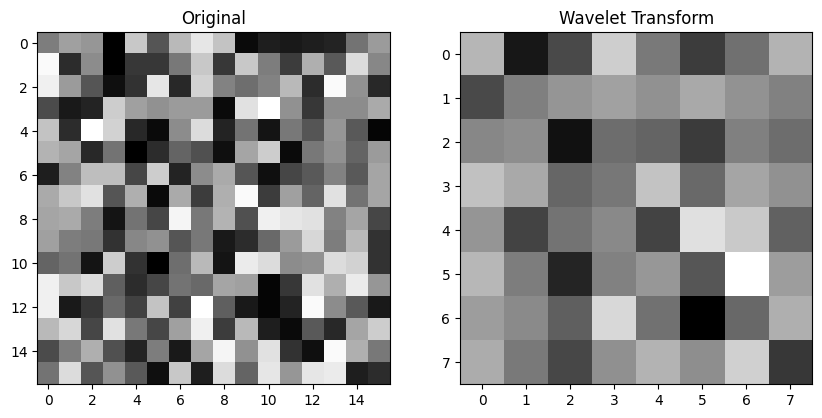

In [211]:
# imshow(np.concatenate((example,idwt), axis = 1))
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(example, cmap='gray')
ax[0].set_title('Original')
ax[1].imshow((idwt), cmap='gray')
ax[1].set_title('Wavelet Transform')
plt.show()

## IMAGES EXAMPLES

In [109]:
photo = 'imagen.jpg'

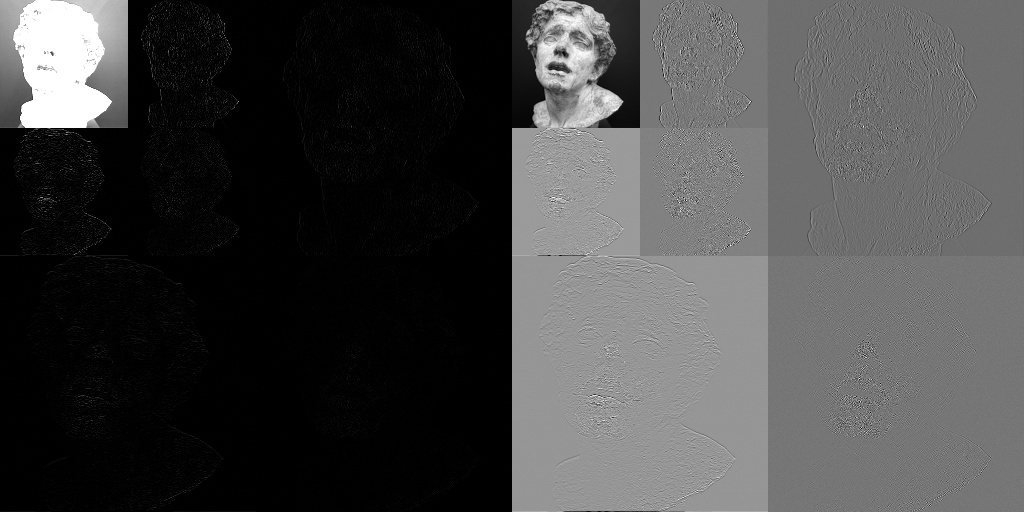

In [185]:
array_photo = jpg_to_pgm(photo)
daubechies_4 = function_daubechies_coeffs(array_photo)
scale, width = 2, array_photo.shape[0]
result_img, normalized= daubechies4_wavelet_transform_2D(daubechies_4,array_photo,scale,width)
# reconstructed = inverse_daubechies4_wavelet_transform_2D(daubechies_4,result_img,scale,width)

imshow(np.concatenate((result_img,normalized), axis = 1))

# fig, ax = plt.subplots(1, 2, figsize=(10, 10))
# ax[0].imshow(array_photo, cmap='gray')
# ax[0].set_title('Original')
# ax[1].imshow((normalized), cmap='gray')
# ax[1].set_title('Wavelet Transform')
# plt.show()